In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
import re
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, Reshape, Flatten
from keras.layers import LSTM, Bidirectional
from keras.datasets import imdb
from keras.callbacks import EarlyStopping

#FYI, meaning of each label for Y:
#1: World
#2: Sports
#3: Business
#4: Sci/Tech


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv',header=None,names=['target','title','text'])
test_data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv',header=None,names=['target','title','text'])

In [ ]:
x_train = train_data['text']
y_train = train_data['target']
x_test = test_data['text']
y_test = test_data['target']

In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4') # for Lemmatization

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
x_train = x_train.apply(lambda x :x.lower()) # all lower cases
x_test = x_test.apply(lambda x :x.lower())
lemm = WordNetLemmatizer()
# Lemmatization is the process of grouping together the different inflected forms of a word
# so they can be analyzed as a single item
print("rocks :", lemm.lemmatize("rocks")) # example
x_train = x_train.apply(lambda x: lemm.lemmatize(x))
x_test = x_test.apply(lambda x: lemm.lemmatize(x))

rocks : rock


In [ ]:
dummy_y_train = pd.get_dummies(y_train).values
dummy_y_test = pd.get_dummies(y_test).values # to match the dimension of the output

(120000, 4)

In [ ]:
token = Tokenizer(num_words=10000,oov_token="<OOV>") # replace any unknown words with OOV, split
token.fit_on_texts(x_train) #  Tokenizer stores everything in the word_index during fit_on_texts
token.fit_on_texts(x_test)
word_index = token.word_index  # so the len(word_index) = # unique word in x.
# text x -> sequences of integers, takes only 10000 most common words

# padding the shorter sentences with zeroes, and truncating some of the longer sequences to be shorter
# post: pad and truncate occur at the end of the sequence (pre=beginning)
train_seq = token.texts_to_sequences(x_train)
train_padd = pad_sequences(train_seq, padding="post", truncating="post",maxlen=60)

test_seq = token.texts_to_sequences(x_test)
test_padd = pad_sequences(test_seq, padding="post", truncating="post",maxlen=60)

In [ ]:
print(train_padd.shape, dummy_y_train.shape)
print(test_padd.shape, dummy_y_test.shape)

(120000, 60) (120000, 4)
(7600, 60) (7600, 4)


In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=10000, output_dim=128, input_length=60))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(64,return_sequences=True)))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(128)))
model.add(keras.layers.Dense(128,activation="relu"))
model.add(keras.layers.Dropout(0.6))
model.add(keras.layers.Dense(4,activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 60, 128)           98816     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               263168    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 5

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_padd, dummy_y_train, epochs=4, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss',patience=0, min_delta=0)])


Epoch 1/4
3000/3000 [==============================] - 780s 258ms/step - loss: 0.3781 - accuracy: 0.8731 - val_loss: 0.3155 - val_accuracy: 0.8881
Epoch 2/4
3000/3000 [==============================] - 765s 255ms/step - loss: 0.2469 - accuracy: 0.9195 - val_loss: 0.3233 - val_accuracy: 0.8909


In [ ]:
model.evaluate(test_padd, dummy_y_test)

238/238 [==============================] - 23s 92ms/step - loss: 0.3022 - accuracy: 0.8993


[0.3021882474422455, 0.8993421196937561]

In [ ]:
predict = model.predict(test_padd)
pred_labels = np.argmax(predict, axis=1)

238/238 [==============================] - 18s 75ms/step


In [ ]:
# for confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, pred_labels)

In [ ]:
confusion_matrix

array([[   0,    0,    0,    0,    0],
       [1719,   39,   85,   57,    0],
       [  40, 1795,   39,   26,    0],
       [  62,    8, 1620,  210,    0],
       [  76,    4,  119, 1701,    0]])

In [ ]:
# I don't know why but somehow confusion_matrix is 5x5 not 4x4, so delete the first row and the last column
confusion_matrix = np.delete(confusion_matrix, 0, 0)


In [ ]:
confusion_matrix = np.delete(confusion_matrix, 4, 1)

In [ ]:
confusion_matrix

array([[1719,   39,   85,   57],
       [  40, 1795,   39,   26],
       [  62,    8, 1620,  210],
       [  76,    4,  119, 1701]])

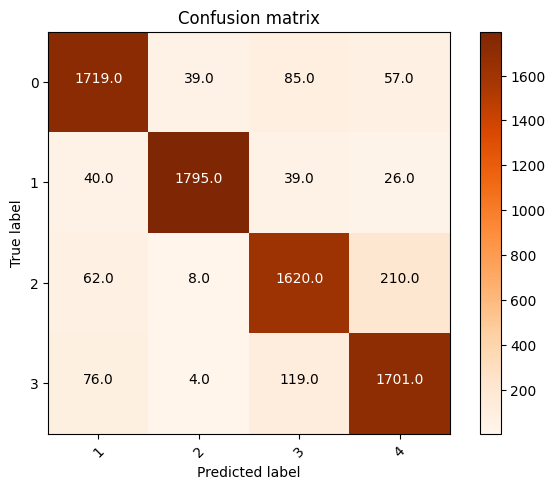

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Oranges):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(cm.shape[1])
    plt.xticks(tick_marks, rotation=45)
    ax = plt.gca()
    ax.set_xticklabels((ax.get_xticks() +1).astype(str))
    plt.yticks(tick_marks)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.1f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


fig, ax = plt.subplots()
plot_confusion_matrix(confusion_matrix)

plt.show()